In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 9.0MB/s 
     |████████████████████████████████| 92kB 12.3MB/s 


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [3]:
%cd /content/drive/My\ Drive/pkl

/content/drive/My Drive/pkl


In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [0]:
df.shape

(8551, 4)

In [0]:
df.sample(10)

,sentence_source,label,label_notes,sentence
2229,l-93,1,NaN,This machine records well.
1124,r-67,0,*,Did that John showed up please you?
141,cj99,0,*,"It is important for the more you eat, the more..."
2650,l-93,0,*,Carla shoveled at the walk.
721,bc01,0,*,Bill proud of himself John doesn't consider.
7099,sgww85,1,NaN,"A policeman walked in at 11, and at 12, a fire..."
1972,r-67,0,*,The writers of any of the reports didn't know ...
1750,r-67,0,*,"Handsome though Dick is fair, Nordic, strong a..."
6404,d_98,1,NaN,The President thanked every soldier who had fo...
6590,g_81,1,NaN,People are said to do crazier things at higher...


In [0]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [0]:

MAX_LEN = 128

In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [0]:

attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:


train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 10

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(data[0], data[3], data[-2])
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(data[-1], data[1], data[2])
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [8]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=11)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
model.load_state_dict(torch.load("Bert3_1.pth"))
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)


In [10]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)A

In [12]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
import sys
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask.long(), labels=b_labels.long())
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
    sys.stdout.write("\rTrain Loss {}".format(tr_loss/batch_size))

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask).long()
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss 110.47023413851858Train loss: 0.6831801740168124


Epoch:  25%|██▌       | 1/4 [18:56<56:50, 1136.91s/it]

Validation Accuracy: 0.8276018099547524
Train Loss 52.59493541540578Train loss: 0.32526243299570673


Epoch:  50%|█████     | 2/4 [37:50<37:52, 1136.05s/it]

Validation Accuracy: 0.8285067873303178
Train Loss 29.825990378379355Train loss: 0.18445263066406528


Epoch:  75%|███████▌  | 3/4 [56:44<18:55, 1135.41s/it]

Validation Accuracy: 0.8036199095022639
Train Loss 17.328377843485214Train loss: 0.10716374671295742


Epoch: 100%|██████████| 4/4 [1:15:39<00:00, 1134.98s/it]

Validation Accuracy: 0.8199095022624443


In [13]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

def acc(y_test,prediction):

    ### PRINTING ACCURACY OF PREDICTION
    ### RECALL
    ### PRECISION
    ### CLASIFICATION REPORT
    ### CONFUSION MATRIX
    cm = confusion_matrix(y_test, prediction)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    
    print ('Recall:', recall)
    print ('Precision:', precision)
    print ('\n clasification report:\n', classification_report(y_test,prediction))
    print ('\n confussion matrix:\n',confusion_matrix(y_test, prediction))
    
    ax = sns.heatmap(confusion_matrix(y_test, prediction),linewidths= 0.5,cmap="YlGnBu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
predictions = []
true_labels  = []
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask).long()
    
            # Move logits and labels to CPU
            # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

            # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [11]:
#!nvidia-smi --gpu-reset -i 0
!nvidia-smi

Sun Apr 26 07:17:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   1723MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Training Evaluation

Let's take a look at our training loss over all batches:

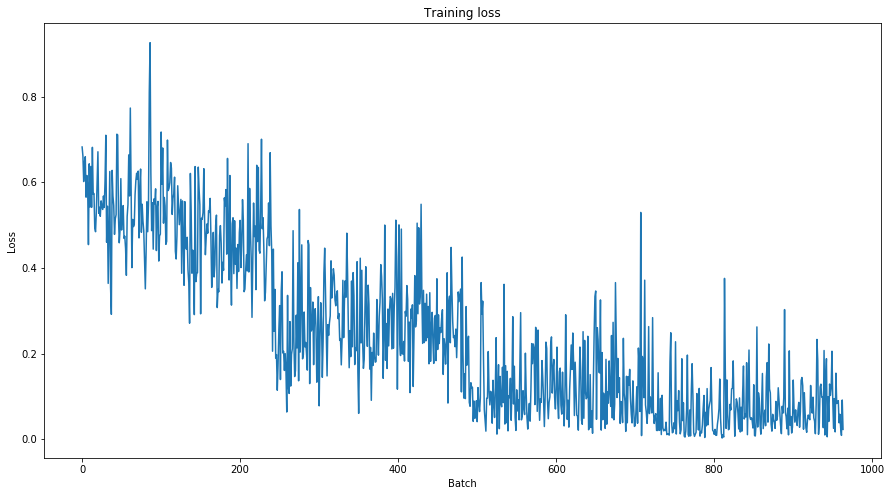

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [28]:
matthews_set

[0.7722137674012959,
 0.747017880833996,
 0.8905088165655366,
 0.7662983918625434,
 0.7738095238095238,
 0.7053601170585435,
 0.8889566369846307,
 0.8916309815169777,
 0.6744186046511628,
 0.8753377726433472,
 0.8902439024390244,
 0.8875,
 0.873326063219467,
 0.8095238095238095,
 0.6785714285714286,
 0.7831893756568048,
 1.0,
 1.0,
 0.5582905262390825,
 0.7685213074469699,
 1.0,
 1.0,
 0.8928571428571429,
 0.8941795301365222,
 0.883191366892423,
 0.8905088165655366,
 0.883191366892423,
 1.0,
 0.7773932581247266,
 1.0,
 0.7848730094898417,
 0.8875,
 0.5607635707790987,
 0.8931103279303892,
 0.8849063286734454,
 1.0,
 0.7901836773196717,
 0.7727092527056634,
 0.6214975391556032,
 0.8877774738226306,
 0.8889566369846307,
 0.4694579005520308,
 0.8875,
 0.6787638492270959,
 0.8902439024390244,
 0.78230849346493,
 0.7102848052045774,
 0.5448623679425841,
 0.78230849346493,
 0.658702969519582,
 0.7859370885787426,
 0.8902439024390244,
 1.0,
 0.8889566369846307,
 0.8953488372093024,
 0.5559369

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [30]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.7996565245698449

Recall: [0.80152672 0.82608696 0.89626556 0.8255814  0.70103093 0.92972973
 0.88432836 0.6848249  0.84705882 0.83098592 0.93518519]
Precision: [0.73684211 0.86363636 0.80297398 0.8875     0.66449511 0.89583333
 0.83450704 0.77192982 0.92307692 0.95546559 0.98058252]

 clasification report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77       262
           1       0.86      0.83      0.84       138
           2       0.80      0.90      0.85       241
           3       0.89      0.83      0.86        86
           4       0.66      0.70      0.68       291
           5       0.90      0.93      0.91       185
           6       0.83      0.88      0.86       268
           7       0.77      0.68      0.73       257
           8       0.92      0.85      0.88        85
           9       0.96      0.83      0.89       284
          10       0.98      0.94      0.96       108

    accuracy                           0.82      2205
   m

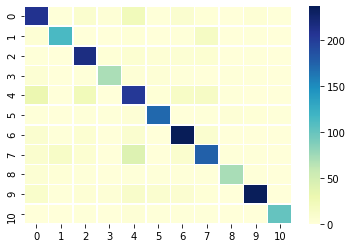

In [34]:
acc(flat_true_labels, flat_predictions)

In [36]:
np.unique(flat_true_labels, return_counts= True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8),
 array([262, 138, 241,  86, 291, 185, 268, 257,  85, 284, 108]))